# Rotten Tomatoes movie review classifier using Keras and Tensorflow

## Author: 
### [Dr. Rahul Remanan](https://www.linkedin.com/in/rahulremanan) {rahul@moad.computer}
### [Dr. Jesse Kanter](https://www.linkedin.com/in/jessekanter) {jessekanter@gmail.com}




*   [Kaggle Rotten Tomatoes datasets](https://www.kaggle.com/c/movie-review-sentiment-analysis-kernels-only/data)
* [This is a modified fork of the Kaggle kernel here](https://www.kaggle.com/nafisur/keras-models-lstm-cnn-gru-bidirectional-glove)


The dataset is comprised of tab-separated files with phrases from the Rotten Tomatoes dataset. The train/test split has been preserved for the purposes of benchmarking, but the sentences have been shuffled from their original order. Each Sentence has been parsed into many phrases by the Stanford parser. Each phrase has a PhraseId. Each sentence has a SentenceId. Phrases that are repeated (such as short/common words) are only included once in the data.

## [Open this notebook in Google CoLab](https://colab.research.google.com/github/rahulremanan/python_tutorial/blob/master/NLP/10-Sentiment_analysis/notebook/Rotten_Tomatoes_movie_reviews_classifier.ipynb)



## Upload Kaggle authentication token

Before downloading the data, ensure that the [terms of the competition](https://www.kaggle.com/c/movie-review-sentiment-analysis-kernels-only/rules) is accepted.

In [0]:
import os

In [0]:
colab_mode = True
download_rawData = True
setup = True

ROOT_DIR = '/content/'
WEIGHTS_FILENAME = 'RT_LSTM.h5'
WEIGHTS_FILE = os.path.join(ROOT_DIR, WEIGHTS_FILENAME)

In [0]:
from google.colab import files

In [0]:
if colab_mode and download_rawData:
  files.upload()

Saving kaggle.json to kaggle.json


In [0]:
if colab_mode and download_rawData:
  ! mkdir /root/.kaggle/
  ! mv /content/kaggle.json /root/.kaggle/

In [0]:
if setup:
  ! pip install kaggle

## Download the Rotten Tomatoes movie reviews dataset

In [0]:
! kaggle competitions download -c movie-review-sentiment-analysis-kernels-only

  0% 0.00/494k [00:00<?, ?B/s]
100% 494k/494k [00:00<00:00, 67.6MB/s]
  0% 0.00/583k [00:00<?, ?B/s]
100% 583k/583k [00:00<00:00, 78.9MB/s]
  0% 0.00/1.28M [00:00<?, ?B/s]
100% 1.28M/1.28M [00:00<00:00, 86.3MB/s]


In [0]:
! kaggle datasets download -d terenceliu4444/glove6b100dtxt

 99% 130M/131M [00:02<00:00, 46.0MB/s]
100% 131M/131M [00:02<00:00, 57.0MB/s]


In [0]:
! rm /root/.kaggle/kaggle.json

In [0]:
if setup:
  ! unzip -q /content/train.tsv.zip
  ! unzip -q /content/test.tsv.zip

In [0]:
if setup:
  ! unzip -q /content/glove6b100dtxt.zip

## Import dependencies

In [0]:
import nltk
import os
import gc
import warnings
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

from keras.preprocessing import sequence,text
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense,Dropout,Embedding,LSTM,Conv1D,GlobalMaxPooling1D,Flatten,MaxPooling1D,GRU,SpatialDropout1D,Bidirectional
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report,f1_score
warnings.filterwarnings("ignore")
#pd.set_option('display.max_colwidth',100)
pd.set_option('display.max_colwidth', -1)

## Read the train data file

In [0]:
train=pd.read_csv('/content/train.tsv',sep='\t')
print(train.shape)
train.head()

(156060, 4)


,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,"A series of escapades demonstrating the adage that what is good for the goose is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story .",1
1,2,1,A series of escapades demonstrating the adage that what is good for the goose,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


## Summarize the training data

### Get the [unqiue label values](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.unique.html) in the training data

The sentiment labels are:

* 0 - negative
* 1 - somewhat negative
* 2 - neutral
* 3 - somewhat positive
* 4 - positive

In [0]:
train['Sentiment'].unique()

array([1, 2, 3, 4, 0])

In [0]:
 Sent_dic={0:'negative', 1:'somewhat negative', 2:'neutral', 3:'somewhat positive', 4:'positive'}


### Count the total number of training items

In [0]:
len(train['Sentiment'])

156060

### Summarize the distribution of the sentiment classes

In [0]:
train.groupby('Sentiment')['PhraseId'].nunique()

Sentiment
0    7072 
1    27273
2    79582
3    32927
4    9206 
Name: PhraseId, dtype: int64

In [0]:
import seaborn as sns

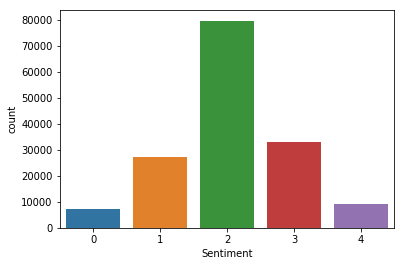

In [0]:
sns.countplot(data=train,x='Sentiment',)

## Load test data

In [0]:
test=pd.read_csv('/content/test.tsv',sep='\t')
print(test.shape)
test.head()

(66292, 3)


,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine effort .
1,156062,8545,An intermittently pleasing but mostly routine effort
2,156063,8545,An
3,156064,8545,intermittently pleasing but mostly routine effort
4,156065,8545,intermittently pleasing but mostly routine


## Load the sample submission file

In [0]:
sub=pd.read_csv('/content/sampleSubmission.csv')
sub.head()

,PhraseId,Sentiment
0,156061,2
1,156062,2
2,156063,2
3,156064,2
4,156065,2


## Create sentiment column in the test dataset

In [0]:
test['Sentiment']=-999
test.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,156061,8545,An intermittently pleasing but mostly routine effort .,-999
1,156062,8545,An intermittently pleasing but mostly routine effort,-999
2,156063,8545,An,-999
3,156064,8545,intermittently pleasing but mostly routine effort,-999
4,156065,8545,intermittently pleasing but mostly routine,-999


## Create a dataframe to store both train and test data

In [0]:
df=pd.concat([train,
              test], ignore_index=True)
print(df.shape)
df.tail()

(222352, 4)


,PhraseId,SentenceId,Phrase,Sentiment
222347,222348,11855,"A long-winded , predictable scenario .",-999
222348,222349,11855,"A long-winded , predictable scenario",-999
222349,222350,11855,"A long-winded ,",-999
222350,222351,11855,A long-winded,-999
222351,222352,11855,predictable scenario,-999


In [0]:
del train,test
gc.collect()

282

## Pre-process the movie review string

In [0]:
from nltk.tokenize import word_tokenize
from nltk import FreqDist
from nltk.stem import SnowballStemmer,WordNetLemmatizer
stemmer=SnowballStemmer('english')
lemma=WordNetLemmatizer()
from string import punctuation
import re

### Download NLTK datasets

Specify the NLTK corpus as 'punkt' or 'all'

In [0]:
if setup:
  nltk.download()

NLTK Downloader
---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> d

Download which package (l=list; x=cancel)?
  Identifier> all
       | 
       | Downloading package abc to /root/nltk_data...
       |   Unzipping corpora/abc.zip.
       | Downloading package alpino to /root/nltk_data...
       |   Unzipping corpora/alpino.zip.
       | Downloading package biocreative_ppi to /root/nltk_data...
       |   Unzipping corpora/biocreative_ppi.zip.
       | Downloading package brown to /root/nltk_data...
       |   Unzipping corpora/brown.zip.
       | Downloading package brown_tei to /root/nltk_data...
       |   Unzipping corpora/brown_tei.zip.
       | Downloading package cess_cat to /root/nltk_data...
       |   Unzipping corpora/cess_cat.zip.
       | Downloading package cess_esp to /root/nltk_data...
 

In [0]:
def clean_review(review_col):
    review_corpus=[]
    for i in range(0,len(review_col)):
        review=str(review_col[i])
        review=re.sub('[^a-zA-Z]',' ',review)
        #review=[stemmer.stem(w) for w in word_tokenize(str(review).lower())]
        review=[lemma.lemmatize(w) for w in word_tokenize(str(review).lower())]
        review=' '.join(review)
        review_corpus.append(review)
    return review_corpus

In [0]:
df['clean_review']=clean_review(df.Phrase.values)
df.head()

,PhraseId,SentenceId,Phrase,Sentiment,clean_review
0,1,1,"A series of escapades demonstrating the adage that what is good for the goose is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story .",1,a series of escapade demonstrating the adage that what is good for the goose is also good for the gander some of which occasionally amuses but none of which amount to much of a story
1,2,1,A series of escapades demonstrating the adage that what is good for the goose,2,a series of escapade demonstrating the adage that what is good for the goose
2,3,1,A series,2,a series
3,4,1,A,2,a
4,5,1,series,2,series


In [0]:
df_train=df[df.Sentiment!=-999]
print (df_train.shape)
df_train.head()

(156060, 5)


,PhraseId,SentenceId,Phrase,Sentiment,clean_review
0,1,1,"A series of escapades demonstrating the adage that what is good for the goose is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story .",1,a series of escapade demonstrating the adage that what is good for the goose is also good for the gander some of which occasionally amuses but none of which amount to much of a story
1,2,1,A series of escapades demonstrating the adage that what is good for the goose,2,a series of escapade demonstrating the adage that what is good for the goose
2,3,1,A series,2,a series
3,4,1,A,2,a
4,5,1,series,2,series


In [0]:
df_test=df[df.Sentiment==-999]
df_test.drop('Sentiment',axis=1,inplace=True)
print(df_test.shape)
df_test.head()

(66292, 4)


,PhraseId,SentenceId,Phrase,clean_review
156060,156061,8545,An intermittently pleasing but mostly routine effort .,an intermittently pleasing but mostly routine effort
156061,156062,8545,An intermittently pleasing but mostly routine effort,an intermittently pleasing but mostly routine effort
156062,156063,8545,An,an
156063,156064,8545,intermittently pleasing but mostly routine effort,intermittently pleasing but mostly routine effort
156064,156065,8545,intermittently pleasing but mostly routine,intermittently pleasing but mostly routine


In [0]:
del df
gc.collect()

26

In [0]:
train_text=df_train.clean_review.values
test_text=df_test.clean_review.values
target=df_train.Sentiment.values

## Convert labels to categorical variables

In [0]:
y=to_categorical(target)
print(train_text.shape,target.shape,y.shape)

(156060,) (156060,) (156060, 5)


## Create train-validation split for training the model

In [0]:
X_train_text,X_val_text,y_train,y_val=train_test_split(train_text,y,test_size=0.2,stratify=y,random_state=123)
print(X_train_text.shape,y_train.shape)
print(X_val_text.shape,y_val.shape)

(124848,) (124848, 5)
(31212,) (31212, 5)


In [0]:
all_words=' '.join(X_train_text)
all_words=word_tokenize(all_words)
dist=FreqDist(all_words)
num_unique_word=len(dist)
num_unique_word

13732

## Finding the maximum length of the review in the training corpus

In [0]:
r_len=[]
for text in X_train_text:
    word=word_tokenize(text)
    l=len(word)
    r_len.append(l)
    
MAX_REVIEW_LEN=np.max(r_len)
MAX_REVIEW_LEN

48

In [0]:
max_features = num_unique_word
max_words = MAX_REVIEW_LEN
batch_size = 128
epochs = 3
num_classes=y.shape[1]
print ('Total number of sentiment classes: {} ...'.format(num_classes))

Total number of sentiment classes: 5 ...


## Tokenize the input text

Tokenizing using [Keras text pre-processor](https://keras.io/preprocessing/text/). This class allows to vectorize a text corpus, by turning each text into either a sequence of integers (each integer being the index of a token in a dictionary) or into a vector where the coefficient for each token could be binary, based on word count, based on tf-idf...

In [0]:
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(X_train_text))
X_train = tokenizer.texts_to_sequences(X_train_text)
X_val = tokenizer.texts_to_sequences(X_val_text)
X_test = tokenizer.texts_to_sequences(test_text)


## Padding the input text for a fixed input length

In [0]:
X_train = sequence.pad_sequences(X_train, maxlen=max_words)
X_val = sequence.pad_sequences(X_val, maxlen=max_words)
X_test = sequence.pad_sequences(X_test, maxlen=max_words)
print(X_train.shape,X_val.shape,X_test.shape)

(124848, 48) (31212, 48)


## The role of [embedding layer in a neural network](https://towardsdatascience.com/deep-learning-4-embedding-layers-f9a02d55ac12)




1.  One-hot encoded vectors are high-dimensional and sparse. Let’s assume that we are doing Natural Language Processing (NLP) and have a dictionary of 2000 words. This means that, when using one-hot encoding, each word will be represented by a vector containing 2000 integers. And 1999 of these integers are zeros. In a big dataset this approach is not computationally efficient.

2.   The vectors of each embedding get updated while training the neural network. If you have seen the image at the top of this post you can see how similarities between words can be found in a multi-dimensional space. This allows us to visualize relationships between words, but also between everything that can be turned into a vector through an embedding layer.

[Read more about keras embedding layer](https://keras.io/layers/embeddings/#embedding)




###LSTM Model
## Create a recurrent neural network model

In [0]:
def model_LSTM():
  model=Sequential()
  model.add(Embedding(max_features,100,mask_zero=True))
  model.add(LSTM(64,dropout=0.4, recurrent_dropout=0.4,return_sequences=True))
  model.add(LSTM(32,dropout=0.5, recurrent_dropout=0.5,return_sequences=False))
  model.add(Dense(4096, activation='tanh'))
  model.add(Dense(num_classes,activation='softmax'))
  return model

## Build and compile the LSTM model

In [0]:
model1 = model_LSTM()

In [0]:
model1.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.001),
              metrics=['accuracy'])
model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 100)         1373200   
_________________________________________________________________
lstm_3 (LSTM)                (None, None, 64)          42240     
_________________________________________________________________
lstm_4 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense_3 (Dense)              (None, 4096)              135168    
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 20485     
Total params: 1,583,509
Trainable params: 1,583,509
Non-trainable params: 0
_________________________________________________________________


## Fetch saved model weights and load the weights file

In [0]:
! wget https://github.com/rahulremanan/python_tutorial/raw/master/NLP/10-Sentiment_analysis/weights/RT_LSTM.h5
  
try:
  model1.load_weights(WEIGHTS_FILE)
  print ('Loaded model weights from: {} ...'.format(WEIGHTS_FILE))
except:
  print ('No model weights file: {} found ...'.format(WEIGHTS_FILE))

--2019-05-20 14:30:54--  https://github.com/rahulremanan/python_tutorial/raw/master/NLP/10-Sentiment_analysis/weights/RT_LSTM.h5
Resolving github.com (github.com)... 192.30.253.113
Connecting to github.com (github.com)|192.30.253.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://media.githubusercontent.com/media/rahulremanan/python_tutorial/master/NLP/10-Sentiment_analysis/weights/RT_LSTM.h5 [following]
--2019-05-20 14:30:54--  https://media.githubusercontent.com/media/rahulremanan/python_tutorial/master/NLP/10-Sentiment_analysis/weights/RT_LSTM.h5
Resolving media.githubusercontent.com (media.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to media.githubusercontent.com (media.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5673112 (5.4M) [application/octet-stream]
Saving to: ‘RT_LSTM.h5.1’

RT_LSTM.h5.1        100%[===================>]   5.4

## Train the model

In [0]:
%%time
history1=model1.fit(X_train, 
                    y_train, 
                    validation_data=(X_val, y_val),
                    epochs=epochs, 
                    batch_size=batch_size, 
                    verbose=1)

Train on 124848 samples, validate on 31212 samples
Epoch 1/3
124848/124848 [==============================] - 311s 2ms/step - loss: 0.7579 - acc: 0.6867 - val_loss: 0.8110 - val_acc: 0.6676
Epoch 2/3
124848/124848 [==============================] - 308s 2ms/step - loss: 0.7272 - acc: 0.6991 - val_loss: 0.8126 - val_acc: 0.6699
Epoch 3/3
124848/124848 [==============================] - 307s 2ms/step - loss: 0.7009 - acc: 0.7069 - val_loss: 0.8082 - val_acc: 0.6714
CPU times: user 21min 53s, sys: 1min 53s, total: 23min 46s
Wall time: 15min 29s


## Save the model weights

In [0]:
model1.save_weights(WEIGHTS_FILE)

In [0]:
files.download(WEIGHTS_FILE)

## Load model weights from weights file

In [0]:
try:
  model1.load_weights(WEIGHTS_FILE)
  print ('Loaded model weights from: {} ...'.format(WEIGHTS_FILE))
except:
  print ('No model weights file: {} found ...'.format(WEIGHTS_FILE))

Loaded model weights from: /content/RT_LSTM.h5 ...


## Running model inference on the test data

In [0]:
test_element=5
input_sequence = np.asarray([list(X_test[test_element])])
y_pred_LSTM=model1.predict(input_sequence,verbose=1)
print ('Input string: {} ...'.format(test_text[test_element]))
print ('Sentiment for the input string: {} ...'.format(Sent_dic[np.argmax(y_pred_LSTM)]))

1/1 [==============================] - 1s 756ms/step
Input string: intermittently pleasing but ...
Sentiment for the input string: neutral ...


In [0]:
print(y_pred_LSTM)
Sent_dic[np.argmax(y_pred_LSTM)]

[[0.00064461 0.01940043 0.6235409  0.33569595 0.02071818]]


'neutral'

## Run inference for custom user input

In [0]:
input_string = ['This movie was horrible']
input_text = tokenizer.texts_to_sequences(input_string)
input_sequence = sequence.pad_sequences(input_text, maxlen=max_words)
y_pred_LSTM=model1.predict(input_sequence,verbose=1)
print ('Input string: {} ...'.format(input_string))
print ('Sentiment for the input string: {} ...'.format(Sent_dic[np.argmax(y_pred_LSTM)]))

1/1 [==============================] - 0s 78ms/step
Input string: ['This movie was horrible'] ...
Sentiment for the input string: negative ...


In [0]:
input_string = ['this movie was great']
input_text = tokenizer.texts_to_sequences(input_string)
input_sequence = sequence.pad_sequences(input_text, maxlen=max_words)
y_pred_LSTM=model1.predict(input_sequence,verbose=1)
print ('Input string: {} ...'.format(input_string))
print ('Sentiment for the input string: {} ...'.format(Sent_dic[np.argmax(y_pred_LSTM)]))

1/1 [==============================] - 0s 79ms/step
Input string: ['this movie was great'] ...
Sentiment for the input string: somewhat positive ...


###CNN Model
## Create a recurrent neural network model

In [0]:
def model_CNN():
  model= Sequential()
  model.add(Embedding(max_features,100,input_length=max_words))
  model.add(Dropout(0.2))
  model.add(Conv1D(64,kernel_size=3,padding='same',activation='relu',strides=1))
  model.add(GlobalMaxPooling1D())
  model.add(Dense(128,activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(num_classes,activation='softmax'))
  return model

## Build and compile the CNN model

In [0]:
model2 = model_CNN()

In [0]:
model2.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 48, 100)           1373200   
_________________________________________________________________
dropout_1 (Dropout)          (None, 48, 100)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 48, 64)            19264     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               8320      
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 5)                 645       
Total para

## Fetch saved model weights and load the weights file

In [0]:
#! wget https://github.com/rahulremanan/python_tutorial/raw/master/NLP/10-Sentiment_analysis/weights/RT_LSTM.h5
  
try:
  model2.load_weights(WEIGHTS_FILE)
  print ('Loaded model weights from: {} ...'.format(WEIGHTS_FILE))
except:
  print ('No model weights file: {} found ...'.format(WEIGHTS_FILE))

--2019-05-20 13:28:12--  https://github.com/rahulremanan/python_tutorial/raw/master/NLP/10-Sentiment_analysis/weights/RT_LSTM.h5
Resolving github.com (github.com)... 192.30.253.113
Connecting to github.com (github.com)|192.30.253.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://media.githubusercontent.com/media/rahulremanan/python_tutorial/master/NLP/10-Sentiment_analysis/weights/RT_LSTM.h5 [following]
--2019-05-20 13:28:12--  https://media.githubusercontent.com/media/rahulremanan/python_tutorial/master/NLP/10-Sentiment_analysis/weights/RT_LSTM.h5
Resolving media.githubusercontent.com (media.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to media.githubusercontent.com (media.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5673112 (5.4M) [application/octet-stream]
Saving to: ‘RT_LSTM.h5’

RT_LSTM.h5          100%[===================>]   5.41M

## Train the model

In [0]:
%%time
history2=model2.fit(X_train, 
                    y_train, 
                    validation_data=(X_val, y_val),
                    epochs=epochs, 
                    batch_size=batch_size, 
                    verbose=1)

Train on 124848 samples, validate on 31212 samples
Epoch 1/3
124848/124848 [==============================] - 11s 86us/step - loss: 0.6453 - acc: 0.7299 - val_loss: 0.8099 - val_acc: 0.6698
Epoch 2/3
124848/124848 [==============================] - 11s 86us/step - loss: 0.6030 - acc: 0.7448 - val_loss: 0.8322 - val_acc: 0.6672
Epoch 3/3
124848/124848 [==============================] - 11s 90us/step - loss: 0.5682 - acc: 0.7593 - val_loss: 0.8665 - val_acc: 0.6547
CPU times: user 33.6 s, sys: 6.15 s, total: 39.7 s
Wall time: 32.7 s


## Save the model weights

In [0]:
model2.save_weights(WEIGHTS_FILE)

In [0]:
files.download(WEIGHTS_FILE)

## Load model weights from weights file

In [0]:
try:
  model2.load_weights(WEIGHTS_FILE)
  print ('Loaded model weights from: {} ...'.format(WEIGHTS_FILE))
except:
  print ('No model weights file: {} found ...'.format(WEIGHTS_FILE))

Loaded model weights from: /content/RT_LSTM.h5 ...


## Running model inference on the test data

In [0]:
test_element=5
input_sequence = np.asarray([list(X_test[test_element])])
y_pred=model2.predict(input_sequence,verbose=1)
print ('Input string: {} ...'.format(test_text[test_element]))
print ('Sentiment for the input string: {} ...'.format(Sent_dic[np.argmax(y_pred)]))

1/1 [==============================] - 0s 3ms/step
Input string: intermittently pleasing but ...
Sentiment for the input string: somewhat positive ...


###CNN +GRUModel
## Create a recurrent neural network model

In [0]:
def model_CNN_GRU():
  model= Sequential()
  model.add(Embedding(max_features,100,input_length=max_words))
  model.add(Conv1D(64,kernel_size=3,padding='same',activation='relu'))
  model.add(MaxPooling1D(pool_size=2))
  model.add(Dropout(0.25))
  model.add(GRU(128,return_sequences=True))
  model.add(Dropout(0.3))
  model.add(Flatten())
  model.add(Dense(128,activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(5,activation='softmax'))
  return model

## Build and compile the CNN +GRU model

In [0]:
model3 = model_CNN_GRU()

In [0]:
model3.compile(loss='categorical_crossentropy',optimizer=Adam(lr=0.001),metrics=['accuracy'])
model3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 48, 100)           1373200   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 48, 64)            19264     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 24, 64)            0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 24, 64)            0         
_________________________________________________________________
gru_1 (GRU)                  (None, 24, 128)           74112     
_________________________________________________________________
dropout_4 (Dropout)          (None, 24, 128)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3072)              0         
__________

## Fetch saved model weights and load the weights file

In [0]:
#! wget https://github.com/rahulremanan/python_tutorial/raw/master/NLP/10-Sentiment_analysis/weights/RT_LSTM.h5
  
try:
  model3.load_weights(WEIGHTS_FILE)
  print ('Loaded model weights from: {} ...'.format(WEIGHTS_FILE))
except:
  print ('No model weights file: {} found ...'.format(WEIGHTS_FILE))

--2019-05-20 13:28:12--  https://github.com/rahulremanan/python_tutorial/raw/master/NLP/10-Sentiment_analysis/weights/RT_LSTM.h5
Resolving github.com (github.com)... 192.30.253.113
Connecting to github.com (github.com)|192.30.253.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://media.githubusercontent.com/media/rahulremanan/python_tutorial/master/NLP/10-Sentiment_analysis/weights/RT_LSTM.h5 [following]
--2019-05-20 13:28:12--  https://media.githubusercontent.com/media/rahulremanan/python_tutorial/master/NLP/10-Sentiment_analysis/weights/RT_LSTM.h5
Resolving media.githubusercontent.com (media.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to media.githubusercontent.com (media.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5673112 (5.4M) [application/octet-stream]
Saving to: ‘RT_LSTM.h5’

RT_LSTM.h5          100%[===================>]   5.41M

## Train the model

In [0]:
%%time
history3=model3.fit(X_train, 
                    y_train, 
                    validation_data=(X_val, y_val),
                    epochs=epochs, 
                    batch_size=batch_size, 
                    verbose=1)

Train on 124848 samples, validate on 31212 samples
Epoch 1/3
124848/124848 [==============================] - 67s 534us/step - loss: 1.0247 - acc: 0.5895 - val_loss: 0.8497 - val_acc: 0.6525
Epoch 2/3
124848/124848 [==============================] - 65s 517us/step - loss: 0.8083 - acc: 0.6680 - val_loss: 0.8118 - val_acc: 0.6681
Epoch 3/3
124848/124848 [==============================] - 65s 518us/step - loss: 0.7290 - acc: 0.6964 - val_loss: 0.8106 - val_acc: 0.6702
CPU times: user 3min 59s, sys: 28.1 s, total: 4min 27s
Wall time: 3min 17s


## Save the model weights

In [0]:
model3.save_weights(WEIGHTS_FILE)

In [0]:
files.download(WEIGHTS_FILE)

## Load model weights from weights file

In [0]:
try:
  model3.load_weights(WEIGHTS_FILE)
  print ('Loaded model weights from: {} ...'.format(WEIGHTS_FILE))
except:
  print ('No model weights file: {} found ...'.format(WEIGHTS_FILE))

Loaded model weights from: /content/RT_LSTM.h5 ...


## Running model inference on the test data

In [0]:
test_element=5
input_sequence = np.asarray([list(X_test[test_element])])
y_pred=model3.predict(input_sequence,verbose=1)
print ('Input string: {} ...'.format(test_text[test_element]))
print ('Sentiment for the input string: {} ...'.format(Sent_dic[np.argmax(y_pred)]))

1/1 [==============================] - 1s 535ms/step
Input string: intermittently pleasing but ...
Sentiment for the input string: somewhat positive ...


###Bidirectional GRU
## Create a recurrent neural network model

In [0]:
def model_BiDir_GRU():
  model = Sequential()
  model.add(Embedding(max_features, 100, input_length=max_words))
  model.add(SpatialDropout1D(0.25))
  model.add(Bidirectional(GRU(128)))
  model.add(Dropout(0.5))
  model.add(Dense(5, activation='softmax'))
  
  return model

## Build and compile the Bidirectional GRU model

In [0]:
model4 = model_BiDir_GRU()

In [0]:
model4.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model4.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 48, 100)           1373200   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 48, 100)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               175872    
_________________________________________________________________
dropout_6 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 5)                 1285      
Total params: 1,550,357
Trainable params: 1,550,357
Non-trainable params: 0
_________________________________________________________________


## Fetch saved model weights and load the weights file

In [0]:
#! wget https://github.com/rahulremanan/python_tutorial/raw/master/NLP/10-Sentiment_analysis/weights/RT_LSTM.h5
  
try:
  model4.load_weights(WEIGHTS_FILE)
  print ('Loaded model weights from: {} ...'.format(WEIGHTS_FILE))
except:
  print ('No model weights file: {} found ...'.format(WEIGHTS_FILE))

--2019-05-20 13:28:12--  https://github.com/rahulremanan/python_tutorial/raw/master/NLP/10-Sentiment_analysis/weights/RT_LSTM.h5
Resolving github.com (github.com)... 192.30.253.113
Connecting to github.com (github.com)|192.30.253.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://media.githubusercontent.com/media/rahulremanan/python_tutorial/master/NLP/10-Sentiment_analysis/weights/RT_LSTM.h5 [following]
--2019-05-20 13:28:12--  https://media.githubusercontent.com/media/rahulremanan/python_tutorial/master/NLP/10-Sentiment_analysis/weights/RT_LSTM.h5
Resolving media.githubusercontent.com (media.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to media.githubusercontent.com (media.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5673112 (5.4M) [application/octet-stream]
Saving to: ‘RT_LSTM.h5’

RT_LSTM.h5          100%[===================>]   5.41M

## Train the model

In [0]:
%%time
history4=model4.fit(X_train, 
                    y_train, 
                    validation_data=(X_val, y_val),
                    epochs=epochs, 
                    batch_size=batch_size, 
                    verbose=1)

Train on 124848 samples, validate on 31212 samples
Epoch 1/3
124848/124848 [==============================] - 205s 2ms/step - loss: 1.0004 - acc: 0.5973 - val_loss: 0.8515 - val_acc: 0.6540
Epoch 2/3
124848/124848 [==============================] - 204s 2ms/step - loss: 0.8017 - acc: 0.6708 - val_loss: 0.8165 - val_acc: 0.6677
Epoch 3/3
124848/124848 [==============================] - 202s 2ms/step - loss: 0.7376 - acc: 0.6952 - val_loss: 0.8059 - val_acc: 0.6720
CPU times: user 14min 50s, sys: 2min 6s, total: 16min 57s
Wall time: 10min 12s


## Save the model weights

In [0]:
model4.save_weights(WEIGHTS_FILE)

In [0]:
files.download(WEIGHTS_FILE)

## Load model weights from weights file

In [0]:
try:
  model4.load_weights(WEIGHTS_FILE)
  print ('Loaded model weights from: {} ...'.format(WEIGHTS_FILE))
except:
  print ('No model weights file: {} found ...'.format(WEIGHTS_FILE))

Loaded model weights from: /content/RT_LSTM.h5 ...


## Running model inference on the test data

In [0]:
test_element=5
input_sequence = np.asarray([list(X_test[test_element])])
y_pred=model4.predict(input_sequence,verbose=1)
print ('Input string: {} ...'.format(test_text[test_element]))
print ('Sentiment for the input string: {} ...'.format(Sent_dic[np.argmax(y_pred)]))

1/1 [==============================] - 1s 727ms/step
Input string: intermittently pleasing but ...
Sentiment for the input string: neutral ...


###Glove word embedding

In [0]:
def get_coefs(word, *arr):
    return word, np.asarray(arr, dtype='float32')
    
def get_embed_mat(EMBEDDING_FILE, max_features,embed_dim):
    # word vectors
    embeddings_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in open(EMBEDDING_FILE, encoding='utf8'))
    print('Found %s word vectors.' % len(embeddings_index))

    # embedding matrix
    word_index = tokenizer.word_index
    num_words = min(max_features, len(word_index) + 1)
    all_embs = np.stack(embeddings_index.values()) #for random init
    embedding_matrix = np.random.normal(all_embs.mean(), all_embs.std(), 
                                        (num_words, embed_dim))
    for word, i in word_index.items():
        if i >= max_features:
            continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    max_features = embedding_matrix.shape[0]
    
    return embedding_matrix

In [0]:
# embedding matrix
EMBEDDING_FILE = '/content/glove.6B.100d.txt'
embed_dim = 100 #word vector dim
embedding_matrix = get_embed_mat(EMBEDDING_FILE,max_features,embed_dim)
print(embedding_matrix.shape)

Found 400000 word vectors.
(13732, 100)



## Create a recurrent neural network model

In [0]:
def model_Glove():
  model = Sequential()
  model.add(Embedding(max_features, embed_dim, input_length=X_train.shape[1],weights=[embedding_matrix],trainable=True))
  model.add(SpatialDropout1D(0.25))
  model.add(Bidirectional(GRU(128,return_sequences=True)))
  model.add(Bidirectional(GRU(64,return_sequences=False)))
  model.add(Dropout(0.5))
  model.add(Dense(num_classes, activation='softmax'))
  
  return model

## Build and compile the Bidirectional GRU model

In [0]:
model5 = model_Glove()

In [0]:
model5.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model5.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 48, 100)           1373200   
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 48, 100)           0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 48, 256)           175872    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 128)               123264    
_________________________________________________________________
dropout_7 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 5)                 645       
Total params: 1,672,981
Trainable params: 1,672,981
Non-trainable params: 0
_________________________________________________________________


## Fetch saved model weights and load the weights file

In [0]:
#! wget https://github.com/rahulremanan/python_tutorial/raw/master/NLP/10-Sentiment_analysis/weights/RT_LSTM.h5
  
try:
  model5.load_weights(WEIGHTS_FILE)
  print ('Loaded model weights from: {} ...'.format(WEIGHTS_FILE))
except:
  print ('No model weights file: {} found ...'.format(WEIGHTS_FILE))

--2019-05-20 13:28:12--  https://github.com/rahulremanan/python_tutorial/raw/master/NLP/10-Sentiment_analysis/weights/RT_LSTM.h5
Resolving github.com (github.com)... 192.30.253.113
Connecting to github.com (github.com)|192.30.253.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://media.githubusercontent.com/media/rahulremanan/python_tutorial/master/NLP/10-Sentiment_analysis/weights/RT_LSTM.h5 [following]
--2019-05-20 13:28:12--  https://media.githubusercontent.com/media/rahulremanan/python_tutorial/master/NLP/10-Sentiment_analysis/weights/RT_LSTM.h5
Resolving media.githubusercontent.com (media.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to media.githubusercontent.com (media.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5673112 (5.4M) [application/octet-stream]
Saving to: ‘RT_LSTM.h5’

RT_LSTM.h5          100%[===================>]   5.41M

## Train the model

In [0]:
%%time
history5=model5.fit(X_train, 
                    y_train, 
                    validation_data=(X_val, y_val),
                    epochs=4, 
                    batch_size=batch_size, 
                    verbose=1)

Train on 124848 samples, validate on 31212 samples
Epoch 1/4
124848/124848 [==============================] - 385s 3ms/step - loss: 0.9975 - acc: 0.5892 - val_loss: 0.8393 - val_acc: 0.6508
Epoch 2/4
124848/124848 [==============================] - 378s 3ms/step - loss: 0.8466 - acc: 0.6487 - val_loss: 0.7938 - val_acc: 0.6716
Epoch 3/4
124848/124848 [==============================] - 378s 3ms/step - loss: 0.7864 - acc: 0.6741 - val_loss: 0.7723 - val_acc: 0.6797
Epoch 4/4
124848/124848 [==============================] - 380s 3ms/step - loss: 0.7473 - acc: 0.6889 - val_loss: 0.7623 - val_acc: 0.6840
CPU times: user 36min 51s, sys: 4min 22s, total: 41min 13s
Wall time: 25min 25s


## Save the model weights

In [0]:
model5.save_weights(WEIGHTS_FILE)

In [0]:
files.download(WEIGHTS_FILE)

## Load model weights from weights file

In [0]:
try:
  model5.load_weights(WEIGHTS_FILE)
  print ('Loaded model weights from: {} ...'.format(WEIGHTS_FILE))
except:
  print ('No model weights file: {} found ...'.format(WEIGHTS_FILE))

Loaded model weights from: /content/RT_LSTM.h5 ...


## Running model inference on the test data

In [0]:
test_element=5
input_sequence = np.asarray([list(X_test[test_element])])
y_pred=model5.predict(input_sequence,verbose=1)
print ('Input string: {} ...'.format(test_text[test_element]))
print ('Sentiment for the input string: {} ...'.format(Sent_dic[np.argmax(y_pred)]))

1/1 [==============================] - 1s 1s/step
Input string: intermittently pleasing but ...
Sentiment for the input string: somewhat positive ...


##Combine all

In [0]:
test_element=5
input_sequence = np.asarray([list(X_test[test_element])])

y_pred1=model1.predict(input_sequence,verbose=1)
y_pred2=model2.predict(input_sequence,verbose=1)
y_pred3=model3.predict(input_sequence,verbose=1)
y_pred4=model4.predict(input_sequence,verbose=1)
y_pred5=model5.predict(input_sequence,verbose=1)

pred1=np.argmax(y_pred1)
pred2=np.argmax(y_pred2)
pred3=np.argmax(y_pred3)
pred4=np.argmax(y_pred4)
pred5=np.argmax(y_pred5)

Sent_all=stats.mode([pred1,pred2,pred3,pred4,pred5],axis=0)[0][0]  

print ('Input string: {} ...'.format(test_text[test_element]))
print ('Sentiment for the input string: {} ...'.format(Sent_dic[Sent_all]))

1/1 [==============================] - 0s 125ms/step
Input string: intermittently pleasing but ...
Sentiment for the input string: somewhat positive ...


In [0]:
y_pred

array([[2.54257699e-04, 1.35154305e-02, 4.51130331e-01, 5.23305535e-01,
        1.17944321e-02]], dtype=float32)

In [0]:
np.mod()